### Import libaries

In [0]:
import pandas as pd
import numpy as np 
import seaborn as sns 
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as ss

### Import data

In [0]:
# Read from url - Take time to run
url = "http://stat-computing.org/dataexpo/2009/2008.csv.bz2"
df = pd.read_csv(url, compression='bz2')

In [0]:
# Reduce rows
df = df.sample(frac=0.25)

In [4]:
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
590996,2008,1,3,4,2003.0,2000,2128.0,2129,DL,1129,N832MH,85.0,89.0,61.0,-1.0,3.0,ATL,MCO,403,8.0,16.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
6930107,2008,12,10,3,854.0,900,1151.0,1200,AA,1681,N499AA,117.0,120.0,96.0,-9.0,-6.0,DFW,SDF,733,5.0,16.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1150435,2008,2,17,7,2126.0,2105,8.0,2346,CO,467,N23707,282.0,281.0,264.0,22.0,21.0,IAH,SEA,1874,6.0,12.0,0,NaN,0,5.0,0.0,1.0,0.0,16.0
3727292,2008,7,2,3,730.0,740,900.0,914,XE,2124,N12946,90.0,94.0,76.0,-14.0,-10.0,LBB,IAH,458,7.0,7.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
5877681,2008,10,9,4,930.0,930,1130.0,1145,AS,342,N795AS,120.0,135.0,100.0,-15.0,0.0,SEA,OAK,671,4.0,16.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN


Variable descriptions: http://stat-computing.org/dataexpo/2009/the-data.html

Reference: https://www.kaggle.com/fabiendaniel/predicting-flight-delays-tutorial

### Data pre-processing

In [5]:
df.count()

Year                 1752432
Month                1752432
DayofMonth           1752432
DayOfWeek            1752432
DepTime              1718494
CRSDepTime           1752432
ArrTime              1714634
CRSArrTime           1752432
UniqueCarrier        1752432
FlightNum            1752432
TailNum              1731643
ActualElapsedTime    1713897
CRSElapsedTime       1752214
AirTime              1713897
ArrDelay             1713897
DepDelay             1718494
Origin               1752432
Dest                 1752432
Distance             1752432
TaxiIn               1714634
TaxiOut              1718306
Cancelled            1752432
CancellationCode       34220
Diverted             1752432
CarrierDelay          382082
WeatherDelay          382082
NASDelay              382082
SecurityDelay         382082
LateAircraftDelay     382082
dtype: int64

In [6]:
#Create Date column
#df['Date'] = pd.to_datetime(df[['Year', 'Month', 'DayofMonth']])

# Drop columns
# Year: The dataset only contains data in 2008
# Cancelled + CancellationCode + Diverted: Cancelled flight does not have delay label.
df.drop(['Year', 'Cancelled', 'CancellationCode', 'Diverted'], axis=1, inplace=True)
# Delay details: Only 20% rows have these features.
df.drop(['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'], axis=1, inplace=True)
# Time: Only keep CRSArrTime, CRSElapsedTime
df.drop(['DepTime', 'ArrTime', 'CRSDepTime', 'ActualElapsedTime'], axis=1, inplace=True)
# Airport: Only keep the Dest Airport
df.drop(['Origin'], axis=1, inplace=True)
# Carrier: Drop FlightNum and TailNum
df.drop(['FlightNum', 'TailNum'], axis=1, inplace=True)

df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

df.count()

Month             1713897
DayofMonth        1713897
DayOfWeek         1713897
CRSArrTime        1713897
UniqueCarrier     1713897
CRSElapsedTime    1713897
AirTime           1713897
ArrDelay          1713897
DepDelay          1713897
Dest              1713897
Distance          1713897
TaxiIn            1713897
TaxiOut           1713897
dtype: int64

In [0]:
# Convert CRSArrTime to Parts of the Day
conditions = [
    (df['CRSArrTime'] >= 500) & (df['CRSArrTime'] < 1201),
    (df['CRSArrTime'] >= 1201) & (df['CRSArrTime'] < 1701),
    (df['CRSArrTime'] >= 1701) & (df['CRSArrTime'] < 2101)]
choices = [1, 2, 3]
df['PotD'] = np.select(conditions, choices, default=4)

# Morning, Afternoon, Evening, Night

In [0]:
# Convert ArrDelay to Delay
# A flight only counts as late if it is more than 30 minutes late.
conditions = [
    (df['ArrDelay'] > 30)]
choices = [1]
df['Delay'] = np.select(conditions, choices, default=0)
df.drop(['CRSArrTime'], axis=1, inplace=True)

In [9]:
df.dtypes

Month               int64
DayofMonth          int64
DayOfWeek           int64
UniqueCarrier      object
CRSElapsedTime    float64
AirTime           float64
ArrDelay          float64
DepDelay          float64
Dest               object
Distance            int64
TaxiIn            float64
TaxiOut           float64
PotD                int64
Delay               int64
dtype: object

In [10]:
df.head()

,Month,DayofMonth,DayOfWeek,UniqueCarrier,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Dest,Distance,TaxiIn,TaxiOut,PotD,Delay
590996,1,3,4,DL,89.0,61.0,-1.0,3.0,MCO,403,8.0,16.0,4,0
6930107,12,10,3,AA,120.0,96.0,-9.0,-6.0,SDF,733,5.0,16.0,1,0
1150435,2,17,7,CO,281.0,264.0,22.0,21.0,SEA,1874,6.0,12.0,4,0
3727292,7,2,3,XE,94.0,76.0,-14.0,-10.0,IAH,458,7.0,7.0,1,0
5877681,10,9,4,AS,135.0,100.0,-15.0,0.0,OAK,671,4.0,16.0,1,0


### Data analysis

In [11]:
#Check basic stats
df.describe()

,Month,DayofMonth,DayOfWeek,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,PotD,Delay
count,1.713897e+06,1.713897e+06,1.713897e+06,1.713897e+06,1.713897e+06,1.713897e+06,1.713897e+06,1.713897e+06,1.713897e+06,1.713897e+06,1.713897e+06,1.713897e+06
mean,6.391131e+00,1.572460e+01,3.923893e+00,1.290237e+02,1.039721e+02,8.208029e+00,9.948220e+00,7.283028e+02,6.861502e+00,1.644992e+01,2.243823e+00,1.317804e-01
std,3.397611e+00,8.800803e+00,1.988067e+00,6.947665e+01,6.740019e+01,3.852994e+01,3.519988e+01,5.626280e+02,4.946154e+00,1.131692e+01,1.019010e+00,3.382519e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,-1.410000e+02,0.000000e+00,-5.190000e+02,-5.340000e+02,2.400000e+01,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,3.000000e+00,8.000000e+00,2.000000e+00,8.000000e+01,5.500000e+01,-1.000000e+01,-4.000000e+00,3.260000e+02,4.000000e+00,1.000000e+01,1.000000e+00,0.000000e+00
50%,6.000000e+00,1.600000e+01,4.000000e+00,1.110000e+02,8.600000e+01,-2.000000e+00,-1.000000e+00,5.810000e+02,6.000000e+00,1.400000e+01,2.000000e+00,0.000000e+00
75%,9.000000e+00,2.300000e+01,6.000000e+00,1.590000e+02,1.320000e+02,1.200000e+01,8.000000e+00,9.540000e+02,8.000000e+00,1.900000e+01,3.000000e+00,0.000000e+00
max,1.200000e+01,3.100000e+01,7.000000e+00,6.600000e+02,1.350000e+03,2.461000e+03,2.457000e+03,4.962000e+03,3.080000e+02,3.700000e+02,4.000000e+00,1.000000e+00


In [12]:
#Check correlation
df.corr()

,Month,DayofMonth,DayOfWeek,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,PotD,Delay
Month,1.000000,0.000479,-0.004164,-0.005145,-0.011209,-0.042004,-0.029925,-0.004253,0.005933,-0.017355,-0.006990,-0.034676
DayofMonth,0.000479,1.000000,0.004348,0.001708,0.000989,0.001296,0.003266,0.001516,-0.002272,-0.000157,-0.001555,0.000196
DayOfWeek,-0.004164,0.004348,1.000000,0.014818,0.013611,0.010802,0.015677,0.016498,0.009786,-0.006354,0.003409,0.011076
CRSElapsedTime,-0.005145,0.001708,0.014818,1.000000,0.988027,0.012211,0.034247,0.983158,0.105714,0.143641,0.089299,0.031137
AirTime,-0.011209,0.000989,0.013611,0.988027,1.000000,0.034893,0.026483,0.982762,0.086621,0.108545,0.076216,0.041282
ArrDelay,-0.042004,0.001296,0.010802,0.012211,0.034893,1.000000,0.930958,0.006228,0.124925,0.321555,0.115357,0.740465
DepDelay,-0.029925,0.003266,0.015677,0.034247,0.026483,0.930958,1.000000,0.025000,0.025889,0.100405,0.140762,0.687466
Distance,-0.004253,0.001516,0.016498,0.983158,0.982762,0.006228,0.025000,1.000000,0.078603,0.091845,0.089078,0.018882
TaxiIn,0.005933,-0.002272,0.009786,0.105714,0.086621,0.124925,0.025889,0.078603,1.000000,0.040851,-0.019041,0.089359
TaxiOut,-0.017355,-0.000157,-0.006354,0.143641,0.108545,0.321555,0.100405,0.091845,0.040851,1.000000,0.057554,0.288969


In [13]:
# Groupby carrier
df.groupby(['UniqueCarrier']).mean()

,Month,DayofMonth,DayOfWeek,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,PotD,Delay
UniqueCarrier,,,,,,,,,,,,
9E,6.514350,15.743281,3.915612,100.365373,71.192445,4.253306,6.812886,450.973674,8.489959,18.123390,2.196062,0.107648
AA,6.449609,15.761861,3.971331,167.301888,141.610651,12.630588,13.184897,1054.472174,8.266507,16.870420,2.322459,0.170676
AQ,1.475299,15.433697,3.928757,74.682267,61.188248,-3.464379,-1.820073,419.305252,3.828913,8.023921,2.103484,0.020281
AS,6.419288,15.664500,3.951995,154.712451,131.564674,4.878173,6.725373,958.610154,5.790839,15.509657,2.342163,0.108905
B6,6.411018,15.879033,4.001366,179.153625,149.621743,11.009479,12.497755,1095.084811,6.246259,21.797347,2.346075,0.168609
CO,6.319479,15.762335,3.897534,186.481467,155.857106,11.107085,13.252221,1154.254790,7.986387,20.492838,2.308408,0.153459
DL,6.498662,15.663874,3.915750,156.407493,127.024405,8.002198,8.127348,925.412169,8.662928,20.595011,2.254390,0.118582
EV,6.482572,15.685360,3.926361,95.646636,69.864224,10.260473,11.967143,444.187608,7.352255,16.723486,2.104642,0.148737
F9,6.467114,15.757461,3.926809,143.520132,121.805227,6.378126,6.052226,881.887004,7.386129,14.654677,2.337654,0.093823


In [14]:
# Groupby destination airport
df.groupby(['Dest']).mean()

,Month,DayofMonth,DayOfWeek,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,PotD,Delay
Dest,,,,,,,,,,,,
ABE,6.485009,15.932099,3.827160,101.332451,74.457672,8.946208,11.157848,539.729277,4.567019,20.096120,2.799824,0.156085
ABI,6.283077,15.906154,3.989231,53.746154,33.873846,9.101538,9.935385,158.000000,3.581538,15.456923,2.687692,0.127692
ABQ,6.425975,15.739556,3.930963,114.619753,92.700840,6.132543,9.188840,656.065679,5.324938,13.537679,2.281679,0.109630
ABY,6.228700,15.937220,4.112108,54.269058,27.439462,9.004484,9.242152,146.000000,3.524664,23.067265,2.587444,0.125561
ACK,7.368932,15.873786,4.029126,86.038835,47.116505,23.504854,17.747573,207.669903,5.776699,38.902913,2.067961,0.281553
ACT,6.216049,15.720165,3.989712,44.936214,23.355967,5.232510,7.220165,89.000000,4.983539,14.609053,2.213992,0.113169
ACV,6.533105,15.696347,3.834475,77.358447,57.242009,12.068493,11.820776,269.528539,4.446347,15.917808,2.449772,0.159817
ACY,2.300000,15.966667,4.200000,114.233333,88.666667,26.333333,26.166667,678.000000,3.300000,22.433333,3.200000,0.133333
ADK,6.636364,12.863636,4.818182,188.136364,170.318182,12.727273,12.454545,1192.000000,4.636364,13.454545,2.681818,0.136364


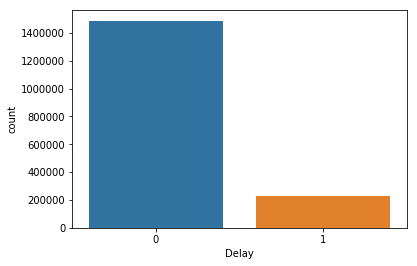

In [15]:
# Bias check
sns.countplot(x="Delay", data=df)

In [0]:
# Check Correlation
def cramers_corrected_stat(x, y):

    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    result=-1
    if len(x.value_counts())==1 :
        print("First variable is constant")
    elif len(y.value_counts())==1:
        print("Second variable is constant")
    else:   
        conf_matrix=pd.crosstab(x, y)

        if conf_matrix.shape[0]==2:
            correct=False
        else:
            correct=True

        chi2 = ss.chi2_contingency(conf_matrix, correction=correct)[0]

        n = sum(conf_matrix.sum())
        phi2 = chi2/n
        r,k = conf_matrix.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        result=np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
    return round(result,6)

#### Month

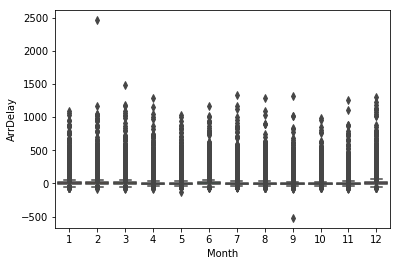

In [17]:
sns.boxplot(x='Month', y='ArrDelay', data=df) #x is feature, y is target

In [18]:
cramers_corrected_stat(df['Delay'], df['Month'])

0.118255

#### DayofMonth

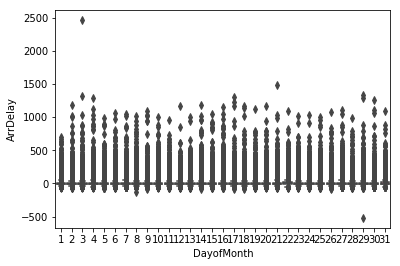

In [19]:
sns.boxplot(x='DayofMonth', y='ArrDelay', data=df) #x is feature, y is target

In [20]:
cramers_corrected_stat(df['Delay'], df['DayofMonth'])

0.03458

#### Weekend

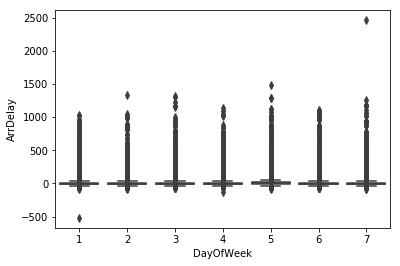

In [21]:
sns.boxplot(x='DayOfWeek', y='ArrDelay', data=df) #x is feature, y is target

In [22]:
cramers_corrected_stat(df['Delay'], df['DayOfWeek'])

0.037551

#### Parts of the Day

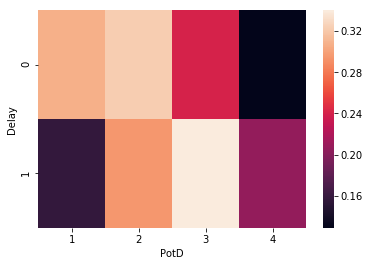

In [23]:
sns.heatmap(pd.crosstab(df['Delay'], df['PotD'], normalize='index'))

In [24]:
cramers_corrected_stat(df['Delay'], df['PotD'])

0.137015

### Encoding

In [0]:
# Apply One-hot encoding to Dest column

df = pd.concat([df, pd.get_dummies(df['Dest'], prefix='Dest',dummy_na=True)],axis=1).drop(['Dest'],axis=1)

In [0]:
# Apply One-hot encoding to UniqueCarrier column

df = pd.concat([df, pd.get_dummies(df['UniqueCarrier'], prefix='UniqueCarrier',dummy_na=True)],axis=1).drop(['UniqueCarrier'],axis=1)

In [27]:
df.head()

,Month,DayofMonth,DayOfWeek,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,PotD,Delay,Dest_ABE,Dest_ABI,Dest_ABQ,Dest_ABY,Dest_ACK,Dest_ACT,Dest_ACV,Dest_ACY,Dest_ADK,Dest_ADQ,Dest_AEX,Dest_AGS,Dest_AKN,Dest_ALB,Dest_ALO,Dest_AMA,Dest_ANC,Dest_ASE,Dest_ATL,Dest_ATW,Dest_AUS,Dest_AVL,Dest_AVP,Dest_AZO,Dest_BDL,Dest_BET,Dest_BFL,Dest_BGM,...,Dest_TPA,Dest_TRI,Dest_TUL,Dest_TUP,Dest_TUS,Dest_TVC,Dest_TWF,Dest_TXK,Dest_TYR,Dest_TYS,Dest_VLD,Dest_VPS,Dest_WRG,Dest_WYS,Dest_XNA,Dest_YAK,Dest_YKM,Dest_YUM,Dest_nan,UniqueCarrier_9E,UniqueCarrier_AA,UniqueCarrier_AQ,UniqueCarrier_AS,UniqueCarrier_B6,UniqueCarrier_CO,UniqueCarrier_DL,UniqueCarrier_EV,UniqueCarrier_F9,UniqueCarrier_FL,UniqueCarrier_HA,UniqueCarrier_MQ,UniqueCarrier_NW,UniqueCarrier_OH,UniqueCarrier_OO,UniqueCarrier_UA,UniqueCarrier_US,UniqueCarrier_WN,UniqueCarrier_XE,UniqueCarrier_YV,UniqueCarrier_nan
590996,1,3,4,89.0,61.0,-1.0,3.0,403,8.0,16.0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6930107,12,10,3,120.0,96.0,-9.0,-6.0,733,5.0,16.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1150435,2,17,7,281.0,264.0,22.0,21.0,1874,6.0,12.0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3727292,7,2,3,94.0,76.0,-14.0,-10.0,458,7.0,7.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5877681,10,9,4,135.0,100.0,-15.0,0.0,671,4.0,16.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Model evaluation

In [0]:
#features = df.drop(['Delay'], axis=1)
# Why?
# Airline:
# Dest Airport + CRSArrTime: 
# Departure features:


X_data = df.drop(['Delay', 'ArrDelay'], axis=1)
y_data = df['Delay']

# Holdout
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0)

In [29]:
X_train.head()

,Month,DayofMonth,DayOfWeek,CRSElapsedTime,AirTime,DepDelay,Distance,TaxiIn,TaxiOut,PotD,Dest_ABE,Dest_ABI,Dest_ABQ,Dest_ABY,Dest_ACK,Dest_ACT,Dest_ACV,Dest_ACY,Dest_ADK,Dest_ADQ,Dest_AEX,Dest_AGS,Dest_AKN,Dest_ALB,Dest_ALO,Dest_AMA,Dest_ANC,Dest_ASE,Dest_ATL,Dest_ATW,Dest_AUS,Dest_AVL,Dest_AVP,Dest_AZO,Dest_BDL,Dest_BET,Dest_BFL,Dest_BGM,Dest_BGR,Dest_BHM,...,Dest_TPA,Dest_TRI,Dest_TUL,Dest_TUP,Dest_TUS,Dest_TVC,Dest_TWF,Dest_TXK,Dest_TYR,Dest_TYS,Dest_VLD,Dest_VPS,Dest_WRG,Dest_WYS,Dest_XNA,Dest_YAK,Dest_YKM,Dest_YUM,Dest_nan,UniqueCarrier_9E,UniqueCarrier_AA,UniqueCarrier_AQ,UniqueCarrier_AS,UniqueCarrier_B6,UniqueCarrier_CO,UniqueCarrier_DL,UniqueCarrier_EV,UniqueCarrier_F9,UniqueCarrier_FL,UniqueCarrier_HA,UniqueCarrier_MQ,UniqueCarrier_NW,UniqueCarrier_OH,UniqueCarrier_OO,UniqueCarrier_UA,UniqueCarrier_US,UniqueCarrier_WN,UniqueCarrier_XE,UniqueCarrier_YV,UniqueCarrier_nan
5048323,9,3,3,84.0,63.0,-2.0,391,7.0,15.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
6336149,11,23,7,115.0,92.0,-2.0,576,9.0,11.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1268423,3,31,1,155.0,129.0,1.0,919,3.0,9.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1158981,2,1,5,74.0,45.0,-3.0,270,3.0,29.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2760071,5,28,3,290.0,274.0,1.0,1946,14.0,10.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


#### Naive Bayes

In [0]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [31]:
# Metrics
# https://medium.com/thalus-ai/performance-metrics-for-classification-problems-in-machine-learning-part-i-b085d432082b
# Confusion Matrix
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))

# Report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

[[141025  97024]
 [  4312  31825]]
              precision    recall  f1-score   support

           0       0.97      0.59      0.74    238049
           1       0.25      0.88      0.39     36137

    accuracy                           0.63    274186
   macro avg       0.61      0.74      0.56    274186
weighted avg       0.87      0.63      0.69    274186



#### Logistic Regression using GridSearchCV

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

grid = {'C' : [1, 5, 10],
       'class_weight' : ['balanced']}

model_cv = GridSearchCV(estimator = LogisticRegression(), 
                        param_grid = grid, cv = 3, scoring = 'f1', n_jobs = 1)

model_cv.fit(X_data, y_data)

print("tuned hpyerparameters :(best parameters) ",model_cv.best_params_)
print("accuracy :",model_cv.best_score_)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Tune hyper parameters using 3-values-method, with f1 metric.

#### Gradient Boosting

#### Random Forest

# TODO

1. Edit threshhold / class weight
2. PCA: Dimension reducing
3. RFE: Features selection
4. GridsearchCV for tuning
- Tuning with 3 values
- Goal: Precison ~ Recall
5. Compare performances among models